# Init

In [ ]:
!pip install -q transformers datasets

## Importing the dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("sem_eval_2018_task_1", "subtask5.english")

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 6838
    })
    test: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 3259
    })
    validation: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 886
    })
})

In [ ]:
example = dataset['train'][0]
example

{'ID': '2017-En-21441',
 'Tweet': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'anger': False,
 'anticipation': True,
 'disgust': False,
 'fear': False,
 'joy': False,
 'love': False,
 'optimism': True,
 'pessimism': False,
 'sadness': False,
 'surprise': False,
 'trust': True}

In [ ]:
labels = [label for label in dataset['train'].features.keys() if label not in ['ID', 'Tweet']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

# Preprocess

In [ ]:
from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_data(examples):
  # take a batch of texts
  text = examples["Tweet"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()
  
  return encoding

In [ ]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [ ]:
example = encoded_dataset['train'][0]
print(example.keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [ ]:
tokenizer.decode(example['input_ids'])

"[CLS] “ worry is a down payment on a problem you may never have '. joyce meyer. # motivation # leadership # worry [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

In [ ]:
example['labels']

[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]

In [ ]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

['anticipation', 'optimism', 'trust']

In [ ]:
encoded_dataset.set_format("torch")

# Making the model

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w

In [ ]:
batch_size = 8
metric_name = "f1"

In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"distilbert-finetuned-sem_eval-english",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
    
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [ ]:
encoded_dataset['train'][0]['labels'].type()

'torch.FloatTensor'

In [ ]:
encoded_dataset['train']['input_ids'][0]

tensor([  101,  1523,  4737,  2003,  1037,  2091,  7909,  2006,  1037,  3291,
         2017,  2089,  2196,  2031,  1005,  1012, 11830, 11527,  1012,  1001,
        14354,  1001,  4105,  1001,  4737,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
#forward pass
outputs = model(input_ids=encoded_dataset['train']['input_ids'][0].unsqueeze(0), labels=encoded_dataset['train'][0]['labels'].unsqueeze(0))
outputs

SequenceClassifierOutput(loss=tensor(0.6869, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[ 0.0257,  0.0281, -0.0613,  0.0248,  0.0776, -0.0713,  0.1003,  0.0240,
         -0.0644,  0.0600,  0.0336]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Training the model

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.411300,0.322273,0.664874,0.764819,0.260722
2,0.287900,0.310689,0.698324,0.791640,0.284424
3,0.247900,0.314371,0.692231,0.789996,0.279910
4,0.221700,0.323579,0.699950,0.795947,0.284424
5,0.189300,0.340210,0.684355,0.785504,0.265237
6,0.166300,0.354797,0.689907,0.792721,0.255079
7,0.151700,0.359752,0.691370,0.790628,0.260722
8,0.130900,0.371199,0.684737,0.789318,0.246050
9,0.120100,0.382307,0.686553,0.790242,0.243792
10,0.111200,0.385633,0.686516,0.789280,0.251693


TrainOutput(global_step=8550, training_loss=0.19935057305453116, metrics={'train_runtime': 916.331, 'train_samples_per_second': 74.624, 'train_steps_per_second': 9.331, 'total_flos': 2264893642152960.0, 'train_loss': 0.19935057305453116, 'epoch': 10.0})

# Eval

In [ ]:
!pip -q install rouge
!pip -q install sacrebleu


In [ ]:
from transformers import DistilBertTokenizer
from rouge import Rouge
import sacrebleu
from sacrebleu import *

In [ ]:
# Move the model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
def evaluate_model(model, tokenizer, dataset):
    tp = {label: 0 for label in id2label.values()}
    fp = {label: 0 for label in id2label.values()}
    fn = {label: 0 for label in id2label.values()}
    tn = {label: 0 for label in id2label.values()}
    
    for example in dataset['test']:
        encoded_text = {'input_ids': example['input_ids'], 'attention_mask': example['attention_mask']}
        #encoded_text = {k: torch.tensor(v).unsqueeze(0).to(device) for k, v in encoded_text.items()}
        encoded_text = {k: torch.tensor(v).clone().detach().unsqueeze(0).to(device) for k, v in encoded_text.items()}
        output = model(**encoded_text)[0].argmax().item()
        label = [id2label[idx] for idx, l in enumerate(example['labels']) if l == 1.0]
        if not label:
            label = ['none']
        predicted_label = id2label[output]
        for l in id2label.values():
            if l in label and l == predicted_label:
                tp[l] += 1
            elif l in label and l != predicted_label:
                fn[l] += 1
            elif l not in label and l == predicted_label:
                fp[l] += 1
            else:
                tn[l] += 1
    
    accuracy = sum(tp.values()) / sum(tn.values())
    epsilon = 1e-8
    precision = {label: tp[label] / (tp[label] + fp[label] + epsilon) for label in id2label.values()}
    recall = {label: tp[label] / (tp[label] + fn[label] + epsilon) for label in id2label.values()}
    f1_score = {label: 2 * precision[label] * recall[label] / (precision[label] + recall[label] + epsilon) for label in id2label.values()}
    
    #return accuracy, precision, recall, f1_score
    return f1_score, precision, recall, accuracy

In [ ]:
# Evaluate the model
f1_score, precision, recall, accuracy = evaluate_model(model, tokenizer, encoded_dataset)


<ipython-input-34-09080550ad0b>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_text = {k: torch.tensor(v).clone().detach().unsqueeze(0).to(device) for k, v in encoded_text.items()}


In [ ]:
# Print the results
print('F1 score:', f1_score)
print('Precision:', precision)
print('Recall:', recall)
print('Accuracy:', accuracy)

F1 score: {'anger': 0.6841243814472087, 'anticipation': 0.12167300069474771, 'disgust': 0.19527558821778165, 'fear': 0.6535947665837926, 'joy': 0.7990708429130462, 'love': 0.003868471914818792, 'optimism': 0.2805495271347512, 'pessimism': 0.0, 'sadness': 0.5938521862936958, 'surprise': 0.17525772977255819, 'trust': 0.0}
Precision: {'anger': 0.8565573770374787, 'anticipation': 0.3168316831369474, 'disgust': 0.7251461987880031, 'fear': 0.8928571428252551, 'joy': 0.904469763357542, 'love': 0.9999999900000002, 'optimism': 0.8083333332996527, 'pessimism': 0.0, 'sadness': 0.7978910368928315, 'surprise': 0.7083333330381945, 'trust': 0.0}
Recall: {'anger': 0.5694822888231655, 'anticipation': 0.07529411764528719, 'disgust': 0.1128298453128951, 'fear': 0.5154639175151451, 'joy': 0.7156726768327624, 'love': 0.0019379844960864731, 'optimism': 0.1697287839005273, 'pessimism': 0.0, 'sadness': 0.4729166666617404, 'surprise': 0.09999999999411764, 'trust': 0.0}
Accuracy: 0.09948273349847006


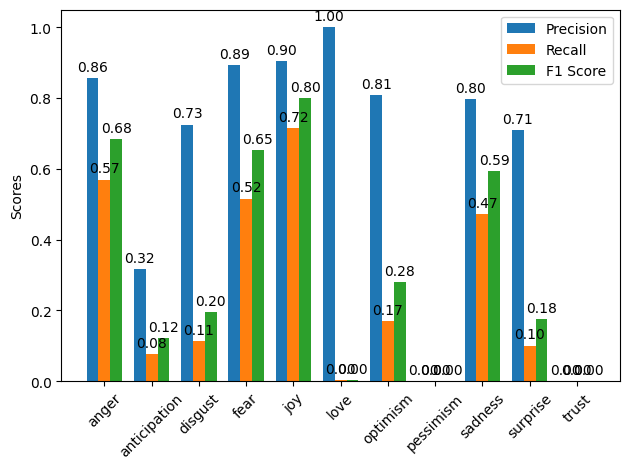

In [ ]:
#Bar graphs
import matplotlib.pyplot as plt
import numpy as np

# Plot bar chart
labels = list(id2label.values())
x = np.arange(len(labels))
width = 0.25
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, list(precision.values()), width, label='Precision')
rects2 = ax.bar(x, list(recall.values()), width, label='Recall')
rects3 = ax.bar(x + width, list(f1_score.values()), width, label='F1 Score')

# Add number labels to the top of each bar
for rects in [rects1, rects2, rects3]:
    for i, rect in enumerate(rects):
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords='offset points',
                    ha='center', va='bottom')

ax.set_ylabel('Scores')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
fig.tight_layout()
plt.show()